In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [10]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from behavior import get_extent

from population import unit_response_matrix, activity_at_phase

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [31]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
selected

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

## Single

In [13]:
session = selected[11]
session

'009266_hippoSIT_2023-05-02_12-22-14'

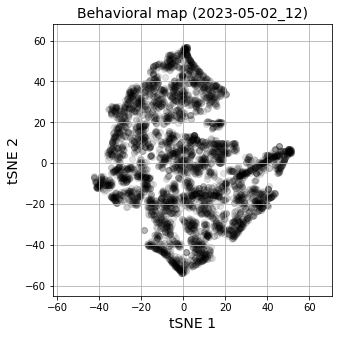

In [14]:
animal = session.split('_')[0]
meta_file        = os.path.join(source, animal, session, 'meta.h5')
moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
with h5py.File(moseq_class_file, 'r') as f:
    idxs_srm_tl = np.array(f['idxs_srm_tl'])
with h5py.File(moseq_class_file, 'r') as f:
    fit = np.array(f[fit_type][str(cfg)])

extent = get_extent(fit, margin=10)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, color='black')
ax.set_title('Behavioral map (%s)' % session[-19:-6], fontsize=14)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel('tSNE 1', fontsize=14)
ax.set_ylabel('tSNE 2', fontsize=14)
ax.grid()

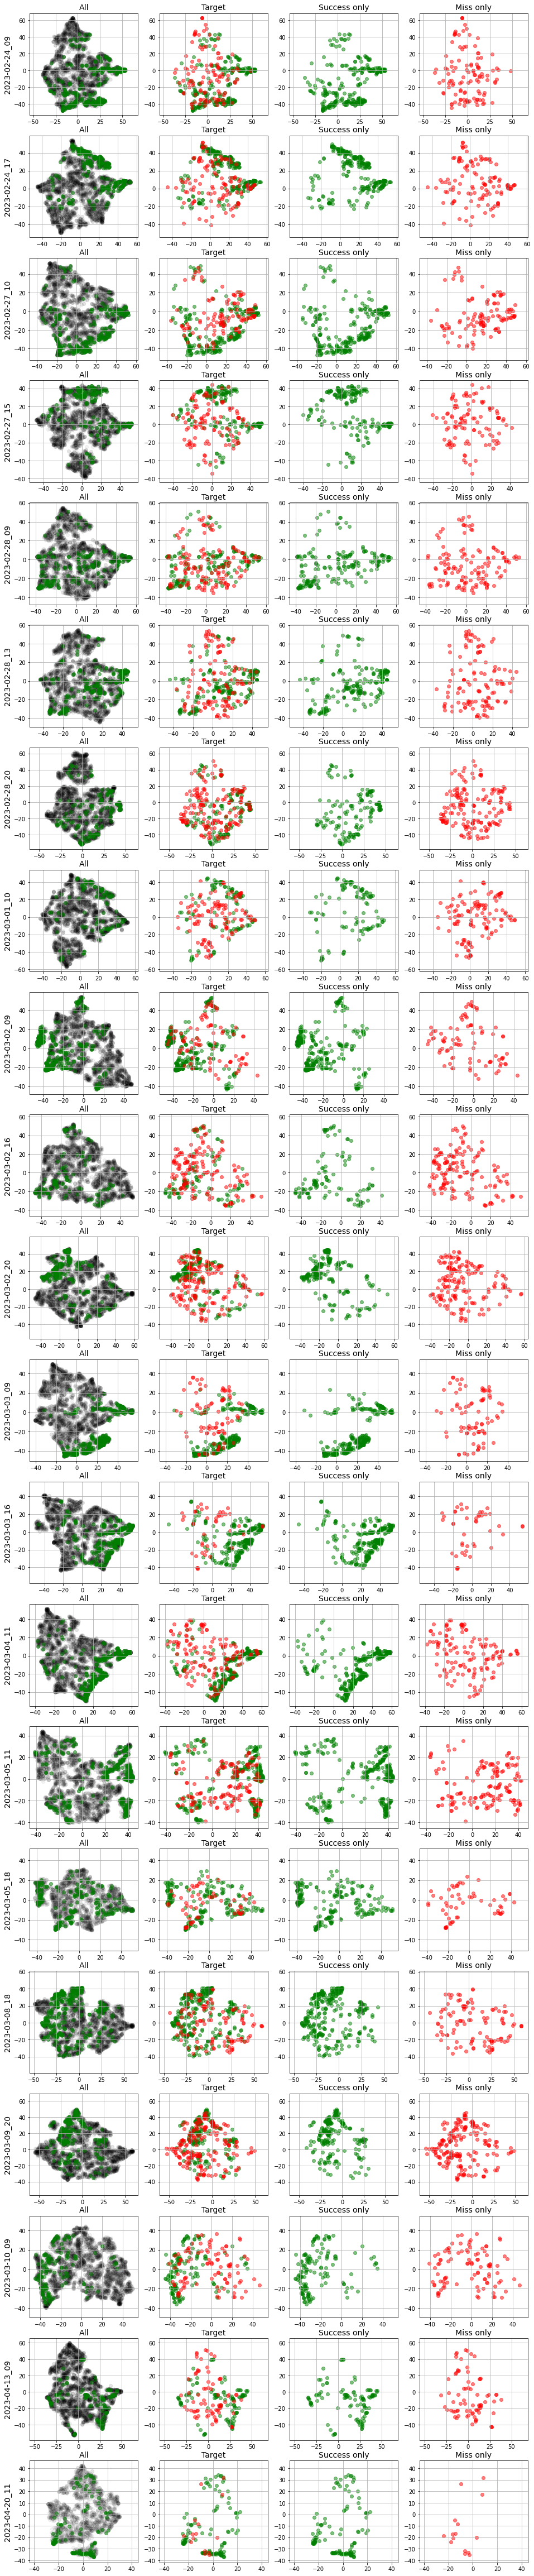

In [32]:
fit_type, cfg = 'tSNE', 70
#fit_type, cfg = 'UMAP', 0.5
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
    with h5py.File(moseq_class_file, 'r') as f:
        fit = np.array(f[fit_type][str(cfg)])
          
    extent = get_extent(fit, margin=5)
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_tgt = np.where(tl[idxs_srm_tl][:, 6] == 2)[0]
    
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
    
    idxs_srm_fail = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 0]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_fail += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
    
    x_min, x_max = fit[:, 0].min(), fit[:, 0].max()
    y_min, y_max = fit[:, 1].min(), fit[:, 1].max()
    idxs_list = [idxs_srm_succ, idxs_srm_succ, idxs_srm_succ, idxs_srm_fail]
    colors    = ['green', 'green', 'green', 'red']
    titles    = ['All', 'Target', 'Success only', 'Miss only']
    for j, idxs in enumerate(idxs_list):
        ax = axes[i][j]
        if j == 0:
            ax.scatter(fit[:, 0], fit[:, 1], alpha=0.05, color='black')
        ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=0.5, color=colors[j])
        if j == 1:
            ax.scatter(fit[idxs_srm_fail][:, 0], fit[idxs_srm_fail][:, 1], alpha=0.5, color='red')
        ax.set_title(titles[j], fontsize=14)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)
        ax.grid()

In [33]:
fig.savefig(os.path.join(report, 'behavior', 'bMAP_succ_fail_%s.pdf' % animal))

## TODO: SHOW ABOVE AS PLACE FIELDS!